In [1]:
# Imports
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage.filters import uniform_filter1d
from sklearn.metrics import classification_report
from collections import namedtuple

In [2]:
# Load data
train = np.loadtxt('kepler_dataset/exoTrain.csv', delimiter=",", skiprows=1, dtype=np.float32)
test = np.loadtxt('kepler_dataset/exoTest.csv', delimiter=",", skiprows=1, dtype=np.float32)

In [4]:
# Preprocess data
train = train[:10]
test = test[:10]

# Normalize all data
train[:,1:] = (train[:,1:] - np.mean(train[:,1:], axis=1).reshape(-1,1) / np.std(train[:,1:], axis=1).reshape(-1,1))
train[:,:1] = train[:,:1] - 1

test[:,1:] = (test[:,1:] - np.mean(test[:,1:], axis=1).reshape(-1,1) / np.std(test[:,1:], axis=1).reshape(-1,1))
test[:,:1] = test[:,:1] - 1

# Augment train data
idx_one = np.where(train[:,:1] == 1)[0]
idx_zero = np.where(train[:,:1] == 0)[0]
start_time = time.time()
for _ in range(len(idx_zero) - len(idx_one)):
    idx_source = np.random.randint(len(idx_one))
    time_shift = np.random.randint(train.shape[1] - 1)
    new_row = np.concatenate((train[idx_source][:1], np.roll(train[idx_source][1:], time_shift)))
    train = np.vstack([train, np.expand_dims(new_row, 0)])
print(time.time() - start_time)
    
# Shuffle train data
np.random.shuffle(train)

# Add dimension
x_train = np.expand_dims(train[:, 1:], axis=2)
x_train = np.concatenate((x_train, uniform_filter1d(x_train, axis=1, size=200)), axis=2)
y_train = np.expand_dims(train[:, 0].astype(np.int32), axis=1)

x_test = np.expand_dims(test[:, 1:], axis=2)
x_test = np.concatenate((x_test, uniform_filter1d(x_test, axis=1, size=200)), axis=2)
y_test = np.expand_dims(test[:, 0].astype(np.int32), axis=1)

In [5]:
# Create Dataset and Iterator
batch_size = 32
tf.reset_default_graph()

# Train dataset
x_train_placeholder = tf.placeholder(x_train.dtype, x_train.shape)
y_train_placeholder = tf.placeholder(y_train.dtype, y_train.shape)
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_placeholder, y_train_placeholder))
train_dataset = train_dataset.batch(batch_size)

# Test dataset
x_test_placeholder = tf.placeholder(x_test.dtype, x_test.shape)
y_test_placeholder = tf.placeholder(y_test.dtype, y_test.shape)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_placeholder, y_test_placeholder))
test_dataset = test_dataset.batch(batch_size)
# Create iterator and its initializers
iterator = tf.data.Iterator.from_structure(train_dataset.output_types, train_dataset.output_shapes)
next_batch = iterator.get_next()
train_iter_init_op = {'fetches': iterator.make_initializer(train_dataset), 
                      'feed_dict': {x_train_placeholder: x_train, y_train_placeholder: y_train}}
test_iter_init_op = {'fetches': iterator.make_initializer(test_dataset), 
                     'feed_dict': {x_test_placeholder: x_test, y_test_placeholder: y_test}}

In [85]:
# Build graph
x_batch, y_batch = next_batch

conv1_w = tf.get_variable('conv_layer1_weights', 
                                      shape=[11, 2, 16], 
                                      dtype=tf.float32, 
                                      initializer=tf.contrib.layers.xavier_initializer())
conv2_w = tf.get_variable('conv_layer2_weights', 
                                      shape=[11, 16, 32], 
                                      dtype=tf.float32, 
                                      initializer=tf.contrib.layers.xavier_initializer())
conv3_w = tf.get_variable('conv_layer3_weights', 
                                      shape=[11, 32, 64], 
                                      dtype=tf.float32, 
                                      initializer=tf.contrib.layers.xavier_initializer())
conv4_w = tf.get_variable('conv_layer4_weights', 
                                      shape=[11, 64, 128], 
                                      dtype=tf.float32, 
                                      initializer=tf.contrib.layers.xavier_initializer())

conv1_b = tf.get_variable('conv_layer1_bias', 16, initializer=tf.constant_initializer(0))
conv2_b = tf.get_variable('conv_layer2_bias', 32, initializer=tf.constant_initializer(0))
conv3_b = tf.get_variable('conv_layer3_bias', 64, initializer=tf.constant_initializer(0))
conv4_b = tf.get_variable('conv_layer4_bias', 128, initializer=tf.constant_initializer(0))

is_train = tf.placeholder(tf.bool)
keep_prob = tf.placeholder(tf.float32)
threshold = tf.placeholder(tf.float32)
learning_rate = tf.placeholder(tf.float32)

model_out = tf.nn.relu(tf.nn.bias_add(tf.nn.conv1d(x_batch, conv1_w, 1, 'VALID'), conv1_b))
model_out = tf.nn.max_pool(tf.expand_dims(model_out, axis=1), ksize=[1, 1, 4, 1], strides=[1, 1, 4, 1], padding='VALID')
#model_out = tf.contrib.layers.batch_norm(model_out, decay=0.9, is_training=is_train, variables_collections=tf.GraphKeys.MOVING_AVERAGE_VARIABLES)
                       
model_out = tf.nn.relu(tf.nn.bias_add(tf.nn.conv1d(tf.squeeze(model_out, axis=1), conv2_w, 1, 'VALID'), conv2_b))
model_out = tf.nn.max_pool(tf.expand_dims(model_out, axis=1), ksize=[1, 1, 4, 1], strides=[1, 1, 4, 1], padding='VALID')
#model_out = tf.contrib.layers.batch_norm(model_out, decay=0.9, is_training=is_train, variables_collections=tf.GraphKeys.MOVING_AVERAGE_VARIABLES)
                       
model_out = tf.nn.relu(tf.nn.bias_add(tf.nn.conv1d(tf.squeeze(model_out, axis=1), conv3_w, 1, 'VALID'), conv3_b))
model_out = tf.nn.max_pool(tf.expand_dims(model_out, axis=1), ksize=[1, 1, 4, 1], strides=[1, 1, 4, 1], padding='VALID')
#model_out = tf.contrib.layers.batch_norm(model_out, decay=0.9, is_training=is_train, variables_collections=tf.GraphKeys.MOVING_AVERAGE_VARIABLES)

model_out = tf.nn.relu(tf.nn.bias_add(tf.nn.conv1d(tf.squeeze(model_out, axis=1), conv4_w, 1, 'VALID'), conv4_b))
model_out = tf.nn.max_pool(tf.expand_dims(model_out, axis=1), ksize=[1, 1, 4, 1], strides=[1, 1, 4, 1], padding='VALID')
#model_out = tf.contrib.layers.batch_norm(model_out, decay=0.9, is_training=is_train, variables_collections=tf.GraphKeys.MOVING_AVERAGE_VARIABLES)

model_out = tf.contrib.layers.flatten(model_out)
model_out = tf.nn.dropout(model_out, keep_prob)
model_out = tf.contrib.layers.fully_connected(model_out, 64)
model_out = tf.nn.dropout(model_out, keep_prob)
model_out = tf.contrib.layers.fully_connected(model_out, 64)
model_out = tf.nn.dropout(model_out, keep_prob)
model_out = tf.contrib.layers.fully_connected(model_out, 64)
model_out = tf.nn.dropout(model_out, keep_prob)
model_out = tf.contrib.layers.fully_connected(model_out, 1, activation_fn=None)

loss = tf.losses.sigmoid_cross_entropy(y_batch, model_out)
loss += 5e-3 * (tf.nn.l2_loss(conv1_w) + tf.nn.l2_loss(conv2_w) + tf.nn.l2_loss(conv3_w) + tf.nn.l2_loss(conv4_w))
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#with tf.control_dependencies(update_ops):
training_op = tf.train.AdadeltaOptimizer(learning_rate).minimize(loss)
prediction = tf.nn.sigmoid(model_out)
accuracy = tf.reduce_mean(tf.to_float(tf.equal(tf.to_int32(tf.greater(prediction, threshold)), y_batch)))

In [86]:
Epoch_Data = namedtuple('Epoch_data', ['loss', 'accuracy', 'predictions', 'run_time'])

def run_epoch(mode, lr=None, thresh=0.5, keep=0.5):
    if mode is 'train':
        iter_init_op = train_iter_init_op
        batch_op = {'fetches': [loss, prediction, accuracy, training_op] + update_ops, 
                    'feed_dict': {learning_rate: lr, keep_prob: keep, is_train: True, threshold: thresh}}
        
    elif mode is 'infer':
        iter_init_op = test_iter_init_op
        batch_op = {'fetches': [loss, prediction, accuracy], 
                    'feed_dict': {keep_prob: keep, is_train: False, threshold: thresh}}
        
    start_time = time.time()
    losses = []
    predictions = []
    accs = []
    sess.run(**iter_init_op)
    while True:
        try:
            batch_outputs = sess.run(**batch_op)
            
            losses.append(batch_outputs[0])
            predictions.append(batch_outputs[1])
            accs.append(batch_outputs[2])                
        except tf.errors.OutOfRangeError:
            break
    epoch_time = time.time() - start_time
    
    return Epoch_Data(np.mean(losses), np.mean(accs), np.concatenate(predictions), epoch_time)

In [90]:
# Train model
#sess = tf.Session()
#sess.run(tf.global_variables_initializer())

for epoch in range(10):
    train_d = run_epoch('train', lr=0.001, keep=0.9)
    test_d = run_epoch('infer', keep=1.0)
    printables = (epoch+1, train_d.run_time+test_d.run_time, train_d.accuracy, train_d.loss, test_d.accuracy)
    print ("Epoch %02i\tDuration: %02is\tTrain accuracy: %.4f\tTrain loss: %.4f\tTest accuracy: %.4f" % printables) 

Epoch 01	Duration: 02s	Train accuracy: 0.9741	Train loss: 0.2462	Test accuracy: 0.9610
Epoch 02	Duration: 01s	Train accuracy: 0.9740	Train loss: 0.2459	Test accuracy: 0.9627
Epoch 03	Duration: 01s	Train accuracy: 0.9743	Train loss: 0.2880	Test accuracy: 0.9627
Epoch 04	Duration: 01s	Train accuracy: 0.9746	Train loss: 0.2820	Test accuracy: 0.9627
Epoch 05	Duration: 01s	Train accuracy: 0.9729	Train loss: 0.2516	Test accuracy: 0.9627
Epoch 06	Duration: 01s	Train accuracy: 0.9742	Train loss: 0.2846	Test accuracy: 0.9610
Epoch 07	Duration: 01s	Train accuracy: 0.9749	Train loss: 0.2622	Test accuracy: 0.9627
Epoch 08	Duration: 01s	Train accuracy: 0.9752	Train loss: 0.2722	Test accuracy: 0.9627
Epoch 09	Duration: 01s	Train accuracy: 0.9757	Train loss: 0.2623	Test accuracy: 0.9627
Epoch 10	Duration: 01s	Train accuracy: 0.9733	Train loss: 0.2643	Test accuracy: 0.9627


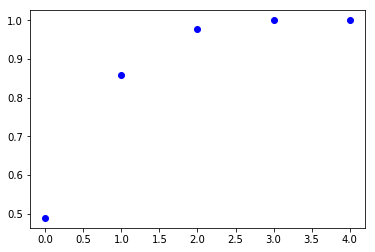

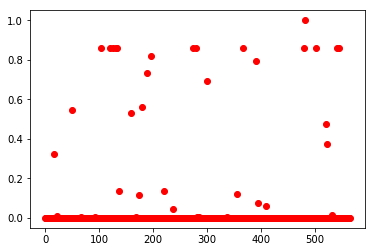

[109, 124, 131, 136, 137, 201, 279, 285, 372, 485, 487, 506, 545, 549]
             precision    recall  f1-score   support

          0       1.00      0.98      0.99       565
          1       0.22      0.80      0.35         5

avg / total       0.99      0.97      0.98       570



In [91]:
train_d = run_epoch('infer', keep=1.0)
predictions = train_d.predictions
non_idx = np.where(y_test[:,0] == 0.)[0]
yes_idx = np.where(y_test[:,0] == 1.)[0]
plt.plot([predictions[i] for i in yes_idx], 'bo')
plt.show()
plt.plot([predictions[i] for i in non_idx], 'ro')
plt.show()
print ([x for x in non_idx if predictions[x] > 0.8])
print (classification_report(y_test, predictions > 0.8))

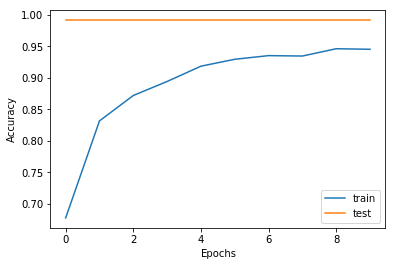

In [7]:
plt.plot(train_accs)
plt.plot(test_accs)
plt.legend(['train', 'test'], loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

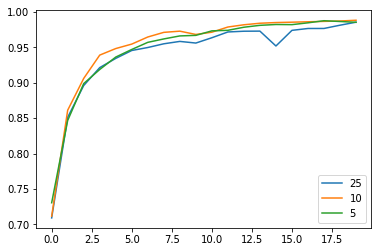

In [33]:
labels = []
for data, label in train_plots:
    if label is '5' or label is '10' or label is '25':
        plt.plot(data)
        labels.append(label)
    
plt.legend(labels, loc='lower right')
plt.show()


[0]


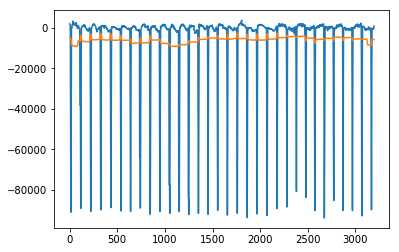

In [92]:
index = 372
print (y_test[index])
plt.plot(x_test[index])
plt.show()